Esse foi um teste de utilização do shap.
Aparentemente o shap não reconhece o nn.flaten -> isso significa que ou a rede precisa ser modificada, ou é necessario outra forma de visualização.

Além disso, o shap plot não esta tão interessante. para muitas labels, ele acaba ficando invisualizavel !!



In [213]:
import torch
from torch import nn

import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [214]:
# 3.1 loss, optimizer, evaluation
#vou importar metricas de uma forma interessante
#importando biblioteca de outros arquivos.py
#abrir o arquivo raw, copiar o link
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download


In [215]:
!pip install shap

In [216]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [217]:
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root= "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform=None
)


In [218]:
class_names = train_data.classes
class_names
#len(class_names)
class_to_idx = train_data.class_to_idx
class_to_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [219]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True) #shuffle só serve pra remover a ordem


test_dataloader = DataLoader(dataset=test_data,
                               batch_size=BATCH_SIZE,
                               shuffle=False) #é mais facil se no test ele não for embaralhado, mais facil pra gente verificar depois

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7bbf9806a590>,
 <torch.utils.data.dataloader.DataLoader at 0x7bbf98068dc0>)

In [220]:
class FashionMNISTModelV2(nn.Module):
  """tiny vgg """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2= nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, #essa é uma adição para que ele funcione. O valor do 7*7 vem da camada anterior, o flatten
                  out_features=output_shape)
    )


  def forward(self, x):
    x = self.conv_block_1(x)
    x=self.conv_block_2(x)
    x=self.classifier(x) #se não mostrar meu classifier significa que eu tenho um problema nele
    return x




In [221]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [222]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [223]:
torch.manual_seed(42)
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f"image batch shape: {images.shape}")
print(f"single image shape: {test_image.shape}")
print(f"test image: {test_image}")



image batch shape: torch.Size([32, 3, 64, 64])
single image shape: torch.Size([3, 64, 64])
test image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [224]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                        out_channels=10,
                        kernel_size=3,
                        stride=1,
                        padding=0)

#pass the data

conv_output = conv_layer(test_image)
conv_output.shape



torch.Size([10, 62, 62])

In [225]:
test_image.shape

torch.Size([3, 64, 64])

In [226]:
conv_output= conv_layer(test_image.unsqueeze(0))
conv_output

tensor([[[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
          [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
          [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
          ...,
          [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
          [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
          [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

         [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
          [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
          [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
          ...,
          [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
          [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
          [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

         [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
          [ 0.8117,  0.3191, -

In [227]:
conv_output.shape

torch.Size([1, 10, 62, 62])

In [228]:
print(f"test image original shape: {test_image.shape}")
print(f"test image with unsqueezes dimension: {test_image.unsqueeze(0).shape}")
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"shape after going trough conv_layer(): {test_image_through_conv.shape} ")

test_image_through_conv_and_max_pool=max_pool_layer(test_image_through_conv)
print(f"shape after going through conv_layer and max pool_layer(): {test_image_through_conv_and_max_pool.shape}")


test image original shape: torch.Size([3, 64, 64])
test image with unsqueezes dimension: torch.Size([1, 3, 64, 64])
shape after going trough conv_layer(): torch.Size([1, 10, 62, 62]) 
shape after going through conv_layer and max pool_layer(): torch.Size([1, 10, 31, 31])


In [229]:
torch.manual_seed(42)

random_tensor = torch.randn(size = (1,1,2,2))
print(f"\n random tensor:\n {random_tensor}")
print(f" random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor=max_pool_layer(random_tensor)
print(f"max pool tensor: {max_pool_tensor}")
print(f"max pool tensor shape: {max_pool_tensor.shape}")


 random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
 random tensor shape: torch.Size([1, 1, 2, 2])
max pool tensor: tensor([[[[0.3367]]]])
max pool tensor shape: torch.Size([1, 1, 1, 1])


In [230]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [231]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [232]:
#track performance

from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """ diferrence between start and end time """
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time



In [233]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):


  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X,y) in enumerate(data_loader):

    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()
    #optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loos: {train_loss:.5f} | train acc: {train_acc: .2f}% \n")

In [234]:
from helper_functions import accuracy_fn
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  """ performs a trining step with model tryin to learn on data_loader."""
  #testing loop
  test_loss, test_acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)

      #forward pass
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)


      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"\n test loss: {test_loss: .5f} | test acc:{test_acc:.2f}%\n")




In [235]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 1
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
-------
Train loos: 0.59518 | train acc:  78.38% 


 test loss:  0.39500 | test acc:85.99%

Train time on cpu: 80.342 seconds


In [236]:
torch.manual_seed(42)
def eval_mode(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):

            X,y = X.to(device), y.to(device)

            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))


        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


In [237]:
model_2_results = eval_mode(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3950044810771942,
 'model_acc': 85.99241214057508}

In [238]:
images.shape


torch.Size([32, 3, 64, 64])

In [239]:
'''
import numpy as np
import shap
test_images_normalized = []
for images, labels in test_dataloader:
    for image in images:
        image_np = image.numpy()
        test_images_normalized.append(image_np)
test_images_normalized = np.array(test_images_normalized) / 255.0

# Convertendo test_images_normalized para tensor PyTorch
test_images_normalized_tensor = torch.tensor(test_images_normalized)

explainer = shap.DeepExplainer(model_2, test_images_normalized_tensor)
'''

'\nimport numpy as np \nimport shap \ntest_images_normalized = []\nfor images, labels in test_dataloader:\n    for image in images:\n        image_np = image.numpy()\n        test_images_normalized.append(image_np)\ntest_images_normalized = np.array(test_images_normalized) / 255.0\n\n# Convertendo test_images_normalized para tensor PyTorch\ntest_images_normalized_tensor = torch.tensor(test_images_normalized)\n\nexplainer = shap.DeepExplainer(model_2, test_images_normalized_tensor)\n'

In [240]:
#labels

Não reconhece nn.flatten


In [241]:
#shap_values = explainer.shap_values(test_images_normalized_tensor)

tentativa de resovler

In [242]:
'''
batch = next(iter(test_dataloader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

test_images
e = shap.DeepExplainer(model_2, background)
shap_values = e.shap_values(test_images)


shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)
'''

'\nbatch = next(iter(test_dataloader))\nimages, _ = batch\n \nbackground = images[:100].to(device)\ntest_images = images[100:105].to(device)\n\ntest_images\ne = shap.DeepExplainer(model_2, background)\nshap_values = e.shap_values(test_images)\n\n\nshap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]\ntest_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)\n\nshap.image_plot(shap_numpy, -test_numpy)\n'

PROPOSTA DE SOLUÇÃO PRA O SHAP !!


In [243]:
from torchvision import datasets
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [244]:
#dropout ajuda a evitar overfitting. ele desativa aleatoriamente um percentual de neuronios, forçando a rede a aprender as caracteristicas mais robustas
#o softmax é usado pra classificação, ele gera probabilidades para cada classe.
'''
o metodo view transforma para um vetor 2d,
 (batch_size, canais, altura, largura)
 ele vai fazer (batch_size*canais*altura*largura, 320)
 ele esta achatando todo meu tensor em um formato (y,320)
-1 é usado para ele calcular automaticamente, de forma que o numero de elemntos do tensor seja preservado. -> achatar sem se preocupar com o tamanho do lote

se usasse 1 em vez de -1=> tensor teria uma linha, fixaria a dimensão, o que seria um erro
'''

batch_size = 128
num_epochs = 1
device = torch.device('cuda:0')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320) #isso pode gerar um erro de dimensionalidade envolvendo o batch size, tem que tomar cuidado.
        x = self.fc_layers(x)
        return x

In [245]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [246]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 10828641.21it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207220.34it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3861358.17it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7526063.78it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [248]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331388
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.336341
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.962157
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.004023
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.859695

Test set: Average loss: 0.0063, Accuracy: 7496/10000 (75%)



In [250]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [251]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

IndexError: index 1 is out of bounds for axis 0 with size 1

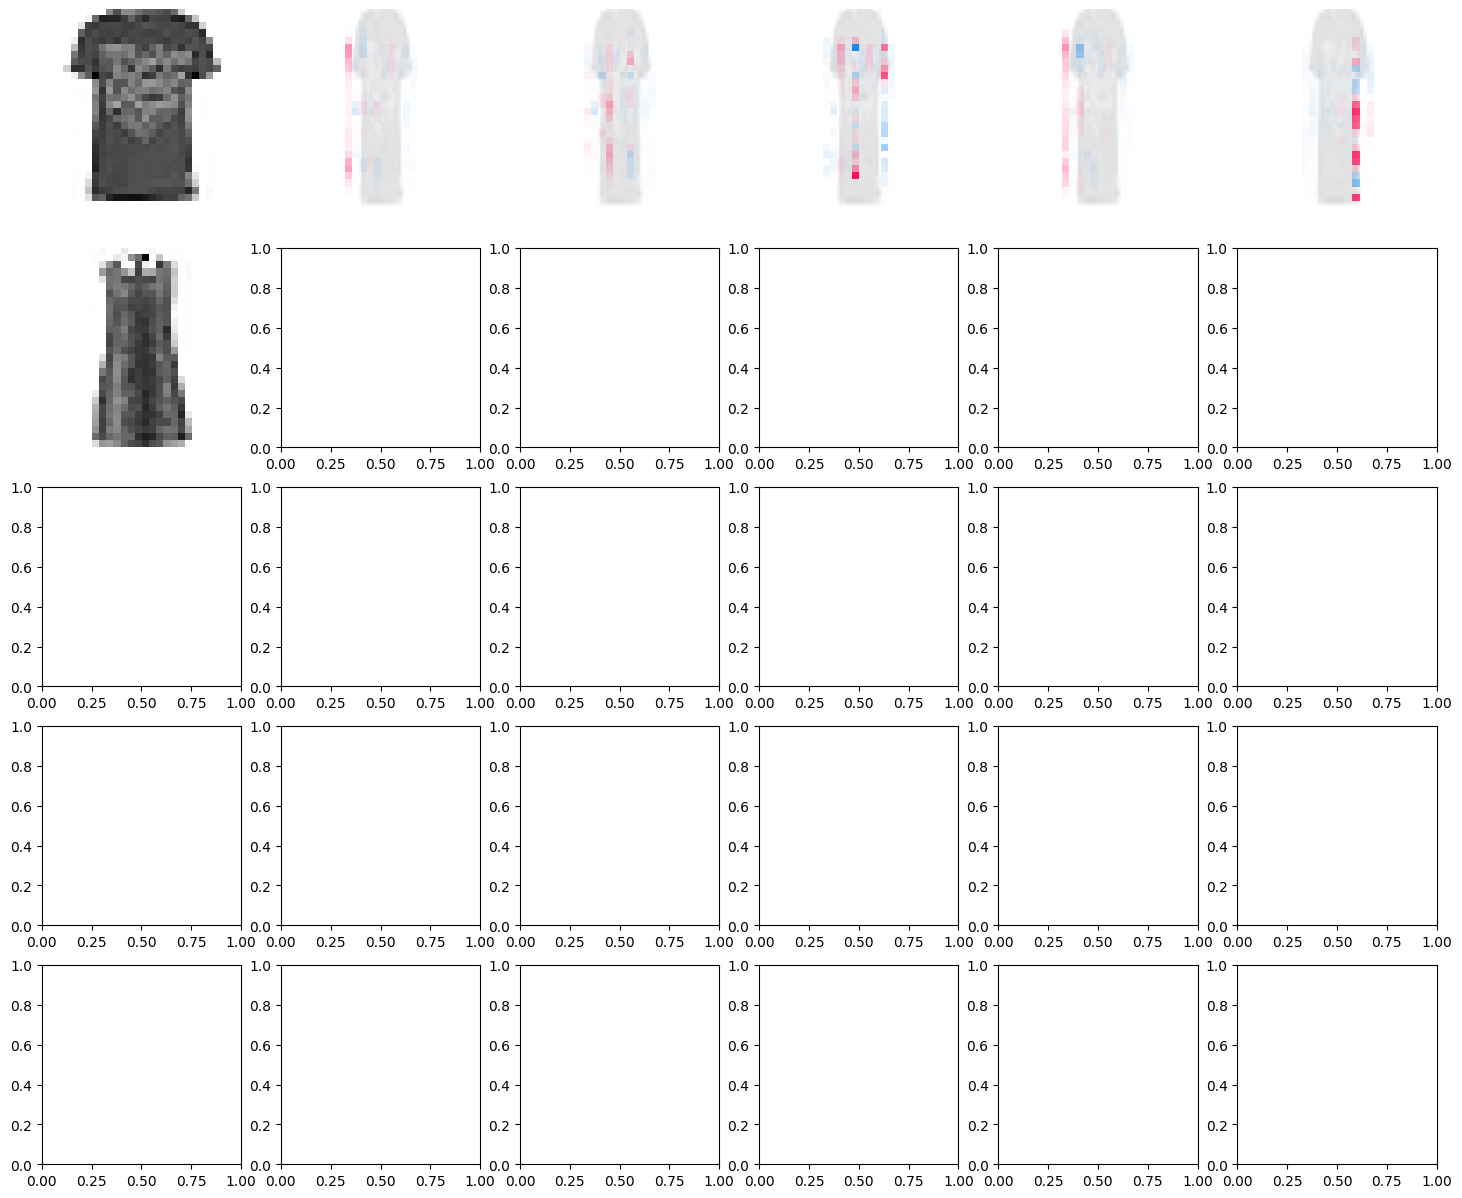

In [252]:

shap.image_plot(shap_numpy, -test_numpy)